***Exploring neural networks using JAX***

------------
"We show that multilayer feedforward networks with as few as one hidden layer are indeed capable of **universal approximation in a very precise and satisfactory way.**" ([Hornik et. al, 1989](https://www.sciencedirect.com/science/article/abs/pii/0893608089900208), p.359)

"[...] any continous function can be uniformly approximated by a continous neural network having only one internal hidden layer and with an arbitraty continous sigmoidal nonlinearity" ([Cybenko, 1989](https://link.springer.com/article/10.1007/BF02551274), p. 312)


"The approximation properties of feed-forward networks have been widely studied (Funahashi, 1989; Cybenko, 1989; Hornik et al., 1989; Stinchecombe and White, 1989; Cotter, 1990; Ito, 1991; Hornik, 1991; Kreinovich, 1991; Ripley, 1996) and found to be very general. **Neural networks are therefore said to be universal approximators**. For example, a two-layer network with linear outputs can uniformly approximate any continuous function on a compact input domain to arbitrary accuracy provided the network has a sufficiently large number of hidden units. This result holds for a wide range of hidden unit activation functions, but excluding polynomials." ([Bishop, 2006](https://link.springer.com/gp/book/9780387310732), p. 230)

# Introduction

The purpose of this notebook is to experimentally explore the theoretical findings of *[Hornik et al. (1989)](https://www.sciencedirect.com/science/article/abs/pii/0893608089900208)* and *[Cybenko (1989)](https://link.springer.com/article/10.1007/BF02551274)* regarding the capacity of neural networks to approximate arbitrarily well any given function. This will be done firstly by trying to approximate six different one dimensional functions with a simple *Feed Forward Neural Network (FFNN)* with one hidden layer and three units. We will then increase the number of units to understand how the quality of the approximation changes. Lastly, this notebook also has the purpose of exploring the tools that [***JAX***](https://jax.readthedocs.io/en/latest/index.html) provides to implement neural networks.

## Function definitions

We will start by defining some basic functions that we will later try to approximate using a simple FFNN.

In [1]:
import jax
import jax.numpy as jnp
from jax import grad, jit
import matplotlib.pyplot as plt
import numpy as np

# Global flag to set a specific platform, must be used at startup.
jax.config.update('jax_platform_name', 'cpu')

In [2]:
# a classic step-wise function
def piecewise_simple(x): 
    return(np.piecewise(x, [x < 0, x >= 0], [-1, 1]))

# a more complicated step-wise function
def piecewise_comp(x): 
    return(np.piecewise(x, [x < 0, x >= 0], [lambda x: np.cos(x), lambda x: x]))

# absolute value function
def abs_value(x): 
    return(np.piecewise(x, [x < 0, x >= 0], [lambda x: -x, lambda x: x]))

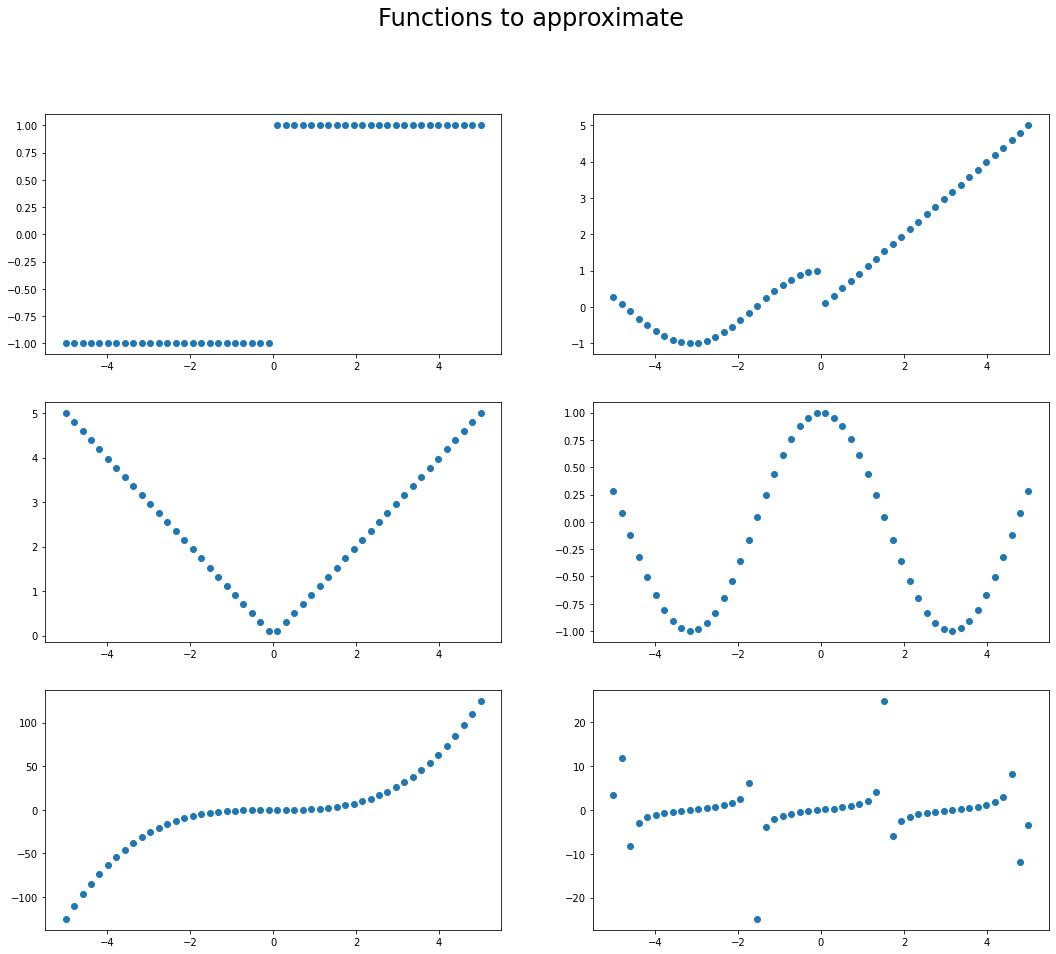

In [3]:
# generate data for several functions
x = np.linspace(-5, 5, 50)
y_pw1 = piecewise_simple(x)
y_pw2 = piecewise_comp(x)
y_abs = abs_value(x)
y_cos = np.cos(x)
y_cube = x**3
y_tan = np.tan(x)

# plot all functions
fig, ax = plt.subplots(3, 2)
fig.set_size_inches(18, 15)
ax[0][0].scatter(x,y_pw1)
ax[0][1].scatter(x,y_pw2)
ax[1][0].scatter(x,y_abs)
ax[1][1].scatter(x,y_cos)
ax[2][0].scatter(x,y_cube)
ax[2][1].scatter(x,y_tan)
fig.suptitle("Functions to approximate", fontsize=24)
plt.show()

## Building a simple Feed Forward Neural Network

We will now use the tools provided by **JAX** to implement a FFNN with one hidden layer. Crucially, we will use the ```grad()``` function to calculate the gradient of the loss function and apply gradient descent to find the optimal parameters. We will also use the ```@jit``` decorator to apply just-in-time compilation and speed-up our functions.

In [4]:
@jit
def forward(params, X):
    # first hidden layer
    h = jax.nn.sigmoid(jnp.dot(X, params["W1"]) + params["b1"])
    preds = jnp.dot(h, params["W2"]) + params["b2"]
    return preds

@jit
def loss(params, X, y):
    # get predictions from the NN
    preds = forward(params, X)
    # calculate the MSE
    squared_errors = (y-preds)**2
    mse = jnp.mean(squared_errors)
    return mse

# create a version of the loss that calculates gradients
loss_grad = grad(loss, argnums=0)

@jit
def update(params, X, y, learning_rate):
    
    # get gradients of loss evaluated at params, X 
    grads = loss_grad(params, X, y)

    # update all the parameters with a manual gradient descent procedure
    new_params = {}
    for name, param in params.items():
        new_params[name] = param - learning_rate*grads[name]

    return new_params

In [5]:
# Define a function for setting in motion the training of the FFNN
def do_training(key, X, y, num_units, learning_rate, epochs):

    # infer the number of "features"
    try:
        input_dim = X.shape[1]
    except IndexError:
        input_dim = 1
        X = np.expand_dims(X, axis=1)

    # initialize random parameters (one hidden layer and one output layer with their respective biases)
    keys = jax.random.split(key, num=4)
    w1 = jax.random.uniform(keys[0], shape=(input_dim, num_units), minval=-1, maxval=1)
    b1 = jax.random.uniform(keys[1], shape=(num_units,), minval=-1, maxval=1)
    w2 = jax.random.uniform(keys[2], shape=(num_units,), minval=-1, maxval=1)
    b2 = jax.random.uniform(keys[3], minval=-1, maxval=1)
    
    # consolidate params into a single dictionary
    params = {"W1": w1, "W2": w2, "b1": b1, "b2": b2}

    # training loop
    all_losses = []
    for epoch in range(epochs):
        # calculate and store loss
        mse_loss = loss(params, X, y)
        all_losses.append(mse_loss)        
        # update parameters
        params = update(params, X, y, learning_rate)

    # plot losses
    plt.plot(list(range(epochs)), all_losses)
    plt.show()

    return all_losses, params

# Performance test

Now that we have defined our FFNN and its training procedure, we can test its performance when approximating the one dimensional functions we introduced earlier.

In [6]:
# define the global parameters
epochs = 10000
learning_rate = 0.005
key = jax.random.PRNGKey(92)
num_units = 3

# generate random X data
x = np.linspace(-5, 5, 50)

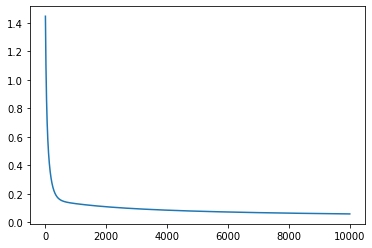

Final mean squared error: 0.05907721444964409




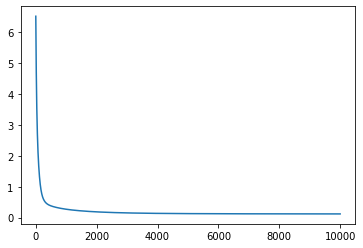

Final mean squared error: 0.12032485753297806




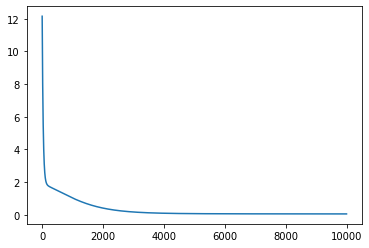

Final mean squared error: 0.04777849093079567




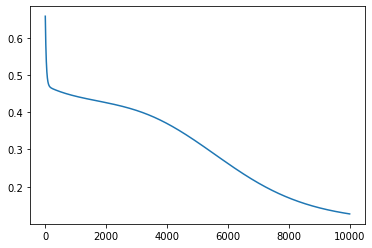

Final mean squared error: 0.12699514627456665




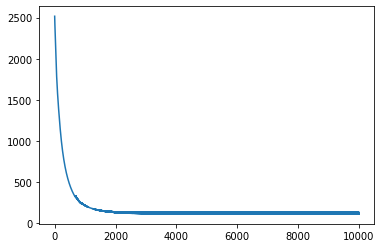

Final mean squared error: 114.94020080566406




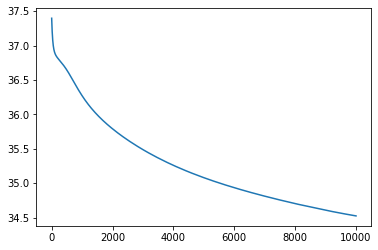

Final mean squared error: 34.52699661254883




In [7]:
# train a FFNN for each function and get predictions
loss_pw1, params_pw1 = do_training(key, x, y_pw1, num_units, learning_rate, epochs)
y_pred_pw1 = forward(params_pw1, np.expand_dims(x, axis=1))
print(f"Final mean squared error: {loss_pw1[-1]}")
print("========================================================\n\n")

loss_pw2, params_pw2 = do_training(key, x, y_pw2, num_units, learning_rate, epochs)
y_pred_pw2 = forward(params_pw2, np.expand_dims(x, axis=1))
print(f"Final mean squared error: {loss_pw2[-1]}")
print("========================================================\n\n")

loss_abs, params_abs  = do_training(key, x, y_abs, num_units, learning_rate, epochs)
y_pred_abs = forward(params_abs, np.expand_dims(x, axis=1))
print(f"Final mean squared error: {loss_abs[-1]}")
print("========================================================\n\n")

loss_cos, params_cos = do_training(key, x, y_cos, num_units, learning_rate, epochs)
y_pred_cos = forward(params_cos, np.expand_dims(x, axis=1))
print(f"Final mean squared error: {loss_cos[-1]}")
print("========================================================\n\n")

loss_cube, params_cube = do_training(key, x, y_cube, num_units, learning_rate, epochs)
y_pred_cube = forward(params_cube, np.expand_dims(x, axis=1))
print(f"Final mean squared error: {loss_cube[-1]}")
print("========================================================\n\n")

loss_tan, params_tan = do_training(key, x, y_tan, num_units, learning_rate, epochs)
y_pred_tan = forward(params_tan, np.expand_dims(x, axis=1))
print(f"Final mean squared error: {loss_tan[-1]}")
print("========================================================\n\n")

From the behaviour of the loss through the training process it looks like we have reached a minima for most of the functions excepto for ```tan()``` and ```cos()```. Let's look at how the predictions from the neural network compare to the actual functions.

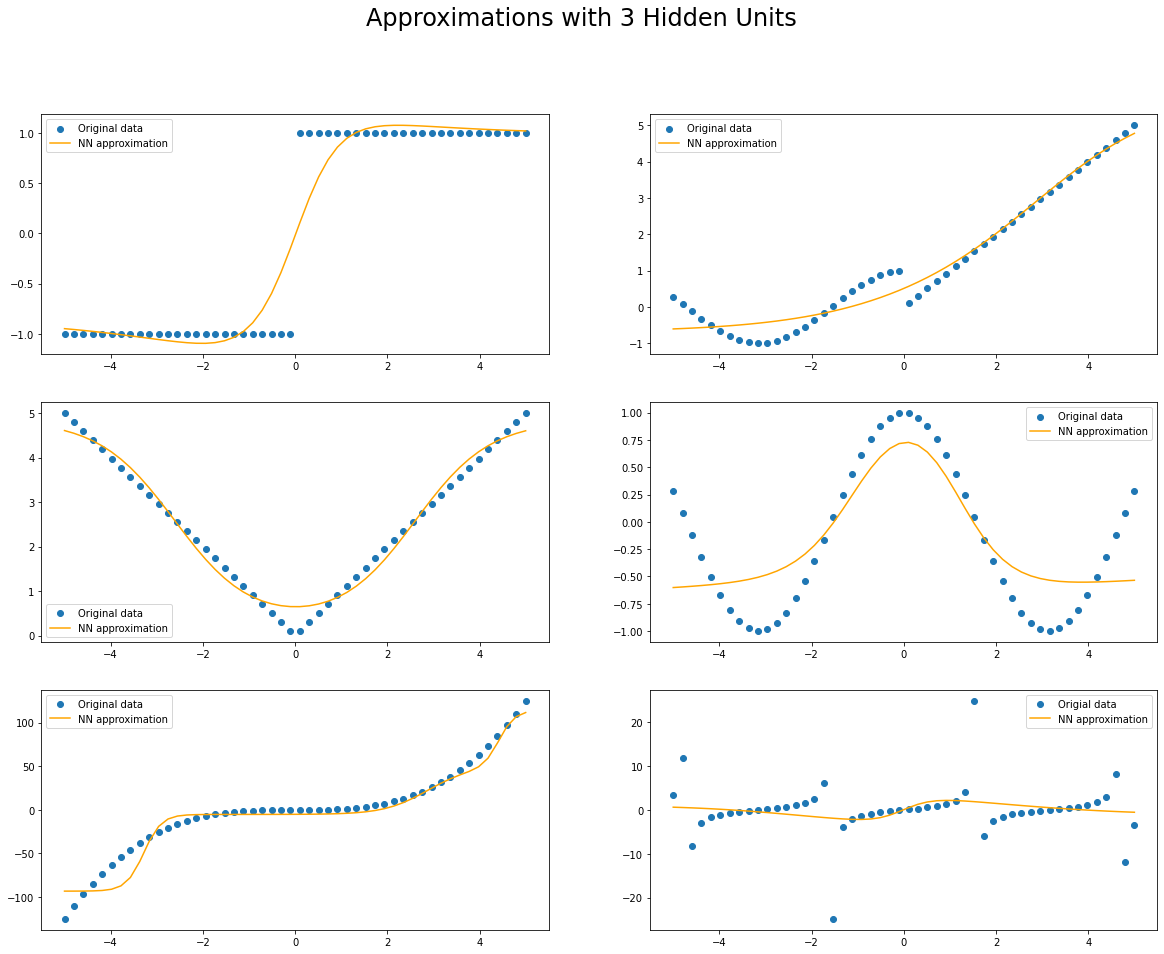

In [8]:
# compare original function with predictions from the trained FFNN
fig, ax = plt.subplots(3, 2)
fig.set_size_inches(20, 15)

ax[0][0].scatter(x, y_pw1, label = "Original data")
ax[0][0].plot(x, y_pred_pw1, label = 'NN approximation', color="orange")
ax[0][0].legend()

ax[0][1].scatter(x,y_pw2, label = "Original data")
ax[0][1].plot(x,y_pred_pw2, label = "NN approximation", color="orange")
ax[0][1].legend()

ax[1][0].scatter(x,y_abs, label = "Original data")
ax[1][0].plot(x,y_pred_abs, label = "NN approximation", color="orange")
ax[1][0].legend()

ax[1][1].scatter(x,y_cos, label = "Original data")
ax[1][1].plot(x,y_pred_cos, label = "NN approximation", color="orange")
ax[1][1].legend()

ax[2][0].scatter(x,y_cube, label = "Original data")
ax[2][0].plot(x,y_pred_cube, label = "NN approximation", color="orange")
ax[2][0].legend()

ax[2][1].scatter(x,y_tan, label = "Origial data")
ax[2][1].plot(x,y_pred_tan, label = "NN approximation", color="orange")
ax[2][1].legend()

fig.suptitle(f"Approximations with {num_units} Hidden Units", fontsize=24)
plt.show()

# Increasing the number of hidden units

We will now increase the number of hidden units of our FFNN to explore how the approximation to the functions changes.

In [15]:
# define the global parameters
epochs = 10000
learning_rate = 0.005
key = jax.random.PRNGKey(92)
num_units = 300

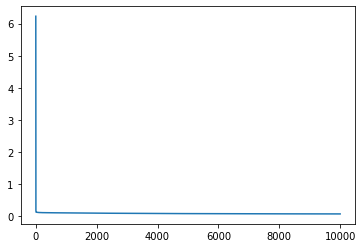

Final mean squared error: 0.0650051012635231




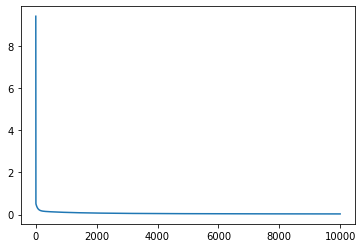

Final mean squared error: 0.02921593189239502




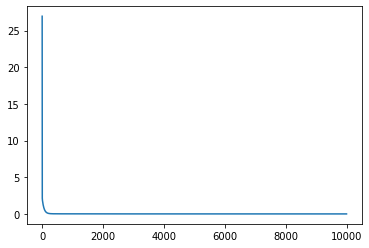

Final mean squared error: 0.013126199133694172




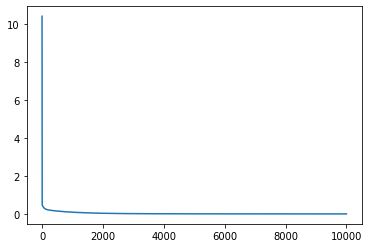

Final mean squared error: 0.011355772614479065




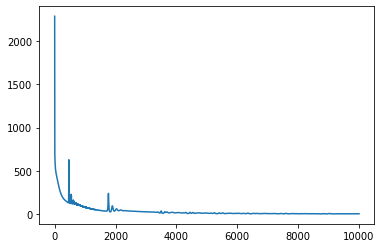

Final mean squared error: 3.4093053340911865




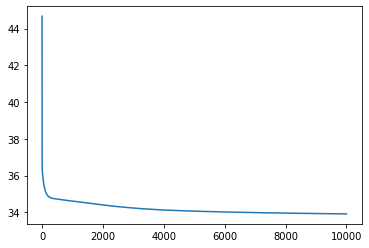

Final mean squared error: 33.90937042236328




In [16]:
# train a FFNN for each function and get predictions
loss_pw1, params_pw1 = do_training(key, x, y_pw1, num_units, learning_rate, epochs)
y_pred_pw1 = forward(params_pw1, np.expand_dims(x, axis=1))
print(f"Final mean squared error: {loss_pw1[-1]}")
print("========================================================\n\n")

loss_pw2, params_pw2 = do_training(key, x, y_pw2, num_units, learning_rate, epochs)
y_pred_pw2 = forward(params_pw2, np.expand_dims(x, axis=1))
print(f"Final mean squared error: {loss_pw2[-1]}")
print("========================================================\n\n")

loss_abs, params_abs  = do_training(key, x, y_abs, num_units, learning_rate, epochs)
y_pred_abs = forward(params_abs, np.expand_dims(x, axis=1))
print(f"Final mean squared error: {loss_abs[-1]}")
print("========================================================\n\n")

loss_cos, params_cos = do_training(key, x, y_cos, num_units, learning_rate, epochs)
y_pred_cos = forward(params_cos, np.expand_dims(x, axis=1))
print(f"Final mean squared error: {loss_cos[-1]}")
print("========================================================\n\n")

loss_cube, params_cube = do_training(key, x, y_cube, num_units, learning_rate, epochs)
y_pred_cube = forward(params_cube, np.expand_dims(x, axis=1))
print(f"Final mean squared error: {loss_cube[-1]}")
print("========================================================\n\n")

loss_tan, params_tan = do_training(key, x, y_tan, num_units, learning_rate, epochs)
y_pred_tan = forward(params_tan, np.expand_dims(x, axis=1))
print(f"Final mean squared error: {loss_tan[-1]}")
print("========================================================\n\n")

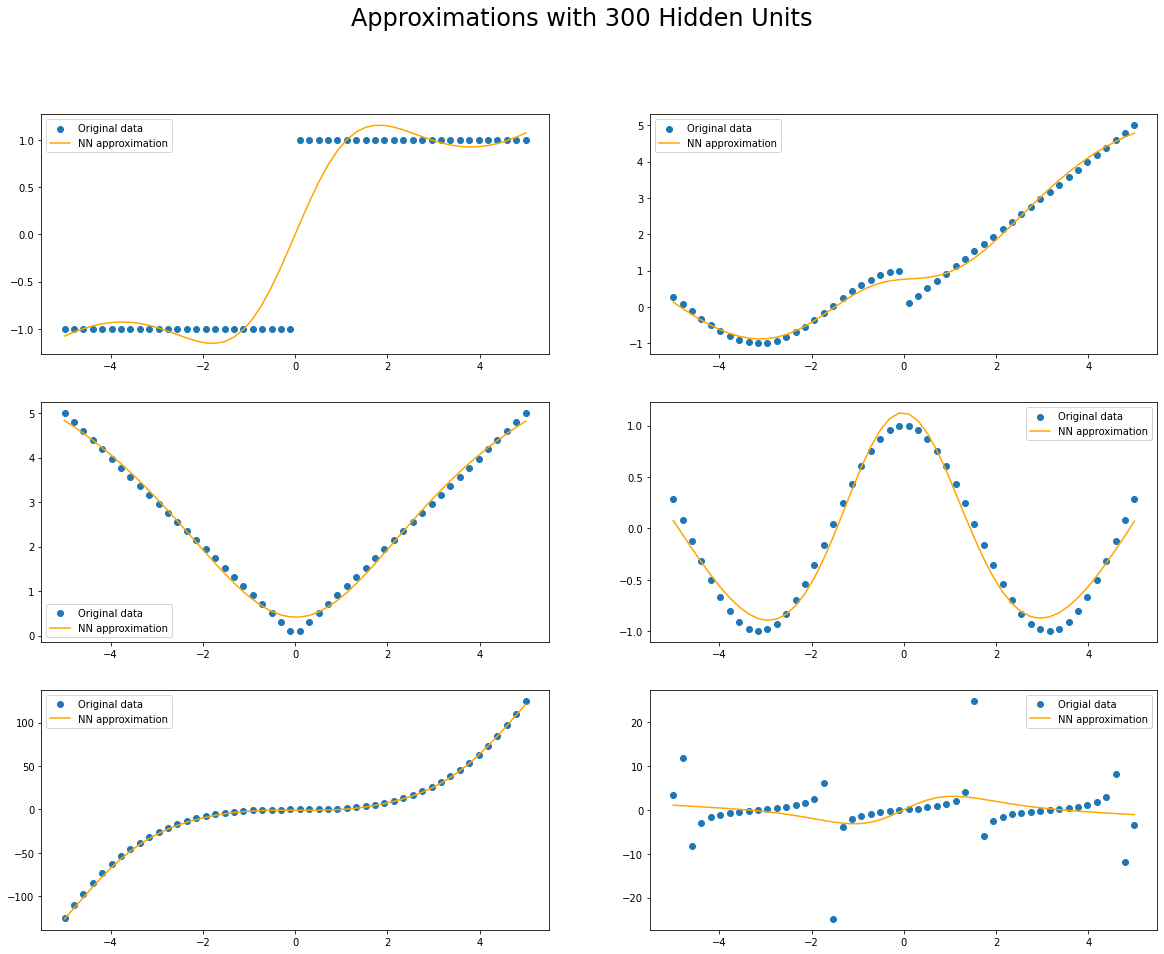

In [17]:
# compare original function with predictions from the trained FFNN
fig, ax = plt.subplots(3, 2)
fig.set_size_inches(20, 15)

ax[0][0].scatter(x, y_pw1, label = "Original data")
ax[0][0].plot(x, y_pred_pw1, label = 'NN approximation', color="orange")
ax[0][0].legend()

ax[0][1].scatter(x,y_pw2, label = "Original data")
ax[0][1].plot(x,y_pred_pw2, label = "NN approximation", color="orange")
ax[0][1].legend()

ax[1][0].scatter(x,y_abs, label = "Original data")
ax[1][0].plot(x,y_pred_abs, label = "NN approximation", color="orange")
ax[1][0].legend()

ax[1][1].scatter(x,y_cos, label = "Original data")
ax[1][1].plot(x,y_pred_cos, label = "NN approximation", color="orange")
ax[1][1].legend()

ax[2][0].scatter(x,y_cube, label = "Original data")
ax[2][0].plot(x,y_pred_cube, label = "NN approximation", color="orange")
ax[2][0].legend()

ax[2][1].scatter(x,y_tan, label = "Origial data")
ax[2][1].plot(x,y_pred_tan, label = "NN approximation", color="orange")
ax[2][1].legend()

fig.suptitle(f"Approximations with {num_units} Hidden Units", fontsize=24)
plt.show()

# Conclusions

Through this brief experimental notebook we were able to see how a single layer FFNN is able to approximate several increasingly complex functions. We also saw how to implement and train these networks using **JAX**. I hope you enjoyed it!